# Data import

In [1]:
import numpy as np
import pandas as pd

df = pd.read_parquet('posts.parquet')
print(f'Loaded {len(df)} posts')
df.head()

# Columns in this dataframe:
# 
#     id:        Reddit post ID on reddit. The post itself can be viewed at
#                https://reddit.com/r/pokemontrades/comments/{id}
#     title:     Post title.
#     body:      Post body (in Markdown format).
#     submitter: The username of the submitter
#     time:      Post submission time, in UTC
#     flair:     Post flair (at the time the post was scraped)
#     hit:       Whether ApriBot's crude detection mechanism (keyword-search) thought the post was Aprimon-related.
#     vote:      /r/BankBallExchange's judgment as to whether the post was Aprimon-related. This is the ground truth.

Loaded 7324 posts


,id,title,body,submitter,time,flair,hit,vote
0,13gxmuw,LF: Drilbur and Solosis FT: Ask,Hello! Im currently in the process of breeding...,Dracon715,2023-05-14 00:35:25,SMUSUM,True,False
1,13gx0eg,"LF: 6IV Non-English Ditto FT: Apriballs, Abili...",I’ve got pretty much everything aside from ✨ m...,MistaKleen,2023-05-14 00:07:42,SV,True,False
2,13gwnha,"LF H-Zoroark and Flabebe Codes, Jiseok Lee Gar...",Also open to other event offers!\n\n\_\_\_\_\_...,ShaikhAndBake,2023-05-13 23:51:47,Event,False,False
3,13gw0vt,"LF: Apriball Stonjourner, Yamask, Honedge, HA ...","Hi! I'm looking for a Stonjourner, Yamask, Hon...",Rainy_Days1115,2023-05-13 23:24:22,SWSH,True,True
4,13gw04b,LF: Sobble. FT: scarlet exclusives/raid exclusive,"It's the only raid exclusive that I'm missing,...",gertygaming,2023-05-13 23:23:23,SV (Closed),False,False


# Text cleaning

In [2]:
import re
import unidecode

def cleanup(text):
    # convert to ASCII
    text = unidecode.unidecode(text, errors='ignore')
    # remove Markdown links
    text = re.sub(r'\[([^\]]+)\]\([^)]+\)', r'\1', text)
    # split on spaces
    words = text.split()
    # remove links (heuristically)
    words = [w for w in words if not w.startswith('http') and not w.startswith('www')]
    # convert curly double/single quotes to plain single quotes
    words = [w.replace('“', "'").replace('”', "'").replace('‘', "'").replace('’', "'") for w in words]
    # split on other punctuation (except apostrophes and hyphens) and convert to lowercase
    words = [w for word in words for w in re.split(r"[^A-Za-z0-9'-]+", word.lower())]
    # remove any remaining punctuation
    words = [re.sub(r"[^A-Za-z0-9]", '', w) for w in words]
    # get rid of anything that doesn't have at least one letter
    words = [s for s in words if any(c.isalpha() for c in s)]
    # string back together
    return ' '.join(words)

df_processed = (df.assign(title=df.title.apply(cleanup))
                  .assign(body=df.body.apply(cleanup))
                  .assign(post=lambda df: df.title + ' ' + df.body)
                  .loc[:, ['id', 'title', 'body', 'post', 'vote']])
df_processed.head()

,id,title,body,post,vote
0,13gxmuw,lf drilbur and solosis ft ask,hello im currently in the process of breeding ...,lf drilbur and solosis ft ask hello im current...,False
1,13gx0eg,lf 6iv nonenglish ditto ft apriballs ability p...,ive got pretty much everything aside from mons...,lf 6iv nonenglish ditto ft apriballs ability p...,False
2,13gwnha,lf hzoroark and flabebe codes jiseok lee garga...,also open to other event offers gen shinies ge...,lf hzoroark and flabebe codes jiseok lee garga...,False
3,13gw0vt,lf apriball stonjourner yamask honedge ha dura...,hi im looking for a stonjourner yamask honedge...,lf apriball stonjourner yamask honedge ha dura...,True
4,13gw04b,lf sobble ft scarlet exclusives raid exclusive,its the only raid exclusive that im missing so...,lf sobble ft scarlet exclusives raid exclusive...,False


# Target data

In [3]:
target = df_processed.vote.to_numpy().astype(int)
target

array([0, 0, 0, ..., 0, 0, 0])

# Train/test splitting

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_processed, target, test_size=0.2, random_state=468)

# Check that the train/test split is balanced.
print(f"1's in test set     : {np.count_nonzero(y_test)} out of {len(y_test)} ({np.count_nonzero(y_test) / len(y_test):.2%})")
print(f"1's in training set : {np.count_nonzero(y_train)} out of {len(y_train)} ({np.count_nonzero(y_train) / len(y_train):.2%})")

1's in test set     : 330 out of 1465 (22.53%)
1's in training set : 1380 out of 5859 (23.55%)


# Feature extraction

`{sep|com}_{ber|mul|mulb|tfidf|ft}` represent feature extractors
which act on the `df_processed` dataframe.
  - `sep`/`com`: whether title/body are separated or combined
  - `ber`/`mul`/`mulb`/`tfidf`: the way to convert words into vectors.
      - `ber`: Bernoulli features (i.e. 0 if word is absent and 1 if word is present)
      - `mul`: multinomial features (the number of times a word appears in the post)
      - `mulb`: multinomial features but using both words and bigrams (pairs of words).
      - `tfidf`: TF-IDF counts
  
Generally, for text vectorisation we don't perform scaling.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.compose import ColumnTransformer
from gensim.models.fasttext import FastText


class FastTextVectorizer():
    """Shim to make FastText behave like a scikit-learn vectoriser."""
    def __init__(self, vector_size=100):
        self.vector_size = vector_size
        
    def fit(self, X, _y=None):
        sentences = [text.split() for text in X]
        self.model = FastText(sentences, vector_size=self.vector_size)
        return self
        
    def get_params(self, deep=True):
        return {}

    def transform(self, X):
        """X is an iterable of sentences"""
        def transform_one(model, words):
            if len(words) == 0:   # Empty text
                return np.zeros(self.vector_size)
            else:
                return np.mean(np.array([model.wv[word] for word in words]), axis=0)
        return np.array([transform_one(self.model, sentence.split()) for sentence in X])

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)


def make_featuriser(comsep, distribution):
    # For everything else we can nicely use existing functionality
    if distribution == 'ber':
        make_vectoriser = lambda: CountVectorizer(binary=True)
    elif distribution == 'mul':
        make_vectoriser = lambda: CountVectorizer()
    elif distribution == 'mulb':
        make_vectoriser = lambda: CountVectorizer(ngram_range=(1, 2))
    elif distribution == 'tfidf':
        make_vectoriser = lambda: TfidfVectorizer()
    elif distribution == 'ft':
        make_vectoriser = lambda: FastTextVectorizer()
    else:
        raise ValueError(f"Invalid value for distribution {distribution}")
        
    if comsep == 'com':     # combine title and body
        return ColumnTransformer([("post", make_vectoriser(), "post")])
    elif comsep == 'sep':   # separate title and body
        return ColumnTransformer([("title", make_vectoriser(), "title"),
                                  ("body", make_vectoriser(), "body")])
    else:
        raise ValueError(f"Invalid value for comsep {comsep}")

featurisers = {
    f'{comsep}_{distribution}': make_featuriser(comsep, distribution)
    for comsep in ['com', 'sep']
    for distribution in ['ber', 'mul', 'mulb', 'tfidf', 'ft']
}

for k in featurisers:
    print(k)

com_ber
com_mul
com_mulb
com_tfidf
com_ft
sep_ber
sep_mul
sep_mulb
sep_tfidf
sep_ft


# Classifiers

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_validate

class KeywordSearch():
    """Our original classifier that uses a keyword search to classify posts."""
    def __init__(self):
        pass
        
    def fit(self, _X, _y):
        return self

    def predict(self, X):
        """Here, X is the original dataframe!"""
        return [int(any(keyword in t.lower()
                       for keyword in ['apri', 'beast', 'dream',
                                       'fast', 'friend', 'heavy',
                                       'level', 'love', 'lure',
                                       'moon', 'safari', 'sport']))
                for t in X.post]
        
def make_classifier(clf):
    if clf == 'bnb':
        return BernoulliNB(alpha=0.1)
    elif clf == 'mnb':
        return MultinomialNB(alpha=0.1)
    elif clf == 'lr':
        return LogisticRegression(max_iter=500)
    elif clf == 'svm':
        return SVC(kernel='rbf', C=1)
    elif clf == 'ada':
        return AdaBoostClassifier(n_estimators=200)
    elif clf == 'rf':
        return RandomForestClassifier(n_estimators=200)
    elif clf == 'gb':
        return GradientBoostingClassifier(n_estimators=200)
    else:
        raise ValueError(f"Invalid value for clf {clf}")


pipelines = {
    # Keyword search
    'keyword': Pipeline([('clf', KeywordSearch())]),
    
    # Bernoulli Naive Bayes
    **{f'{comsep}_{dist}_{clf}': Pipeline([('feat', featurisers[f'{comsep}_{dist}']),
                                           ('clf', make_classifier(clf))])
       for comsep in ['com', 'sep']
       for dist in ['ber']
       for clf in ['bnb']
       },

    # Multinomial Naive Bayes
    **{f'{comsep}_{dist}_{clf}': Pipeline([('feat', featurisers[f'{comsep}_{dist}']),
                                           ('clf', make_classifier(clf))])
       for comsep in ['com', 'sep']
       for dist in ['mul', 'mulb', 'tfidf']
       for clf in ['mnb']},
            
    # Logistic regression
    **{f'{comsep}_{dist}_{clf}': Pipeline([('feat', featurisers[f'{comsep}_{dist}']),
                                           ('clf', make_classifier(clf))])
       for comsep in ['com', 'sep']
       for dist in ['mul', 'mulb', 'tfidf', 'ft']
       for clf in ['lr']},
            
    # Support vector machines
    **{f'{comsep}_{dist}_{clf}': Pipeline([('feat', featurisers[f'{comsep}_{dist}']),
                                           ('clf', make_classifier(clf))])
       for comsep in ['com', 'sep']
       for dist in ['mul', 'mulb', 'tfidf', 'ft']
       for clf in ['svm']},
           
    # Tree-based methods
    **{f'{comsep}_{dist}_{clf}': Pipeline([('feat', featurisers[f'{comsep}_{dist}']),
                                             ('clf', make_classifier(clf))])
         for comsep in ['com', 'sep']
         for dist in ['mul', 'mulb', 'tfidf', 'ft']
         for clf in ['ada', 'rf', 'gb']}
}

for k in pipelines:
    print(k)

keyword
com_ber_bnb
sep_ber_bnb
com_mul_mnb
com_mulb_mnb
com_tfidf_mnb
sep_mul_mnb
sep_mulb_mnb
sep_tfidf_mnb
com_mul_lr
com_mulb_lr
com_tfidf_lr
com_ft_lr
sep_mul_lr
sep_mulb_lr
sep_tfidf_lr
sep_ft_lr
com_mul_svm
com_mulb_svm
com_tfidf_svm
com_ft_svm
sep_mul_svm
sep_mulb_svm
sep_tfidf_svm
sep_ft_svm
com_mul_ada
com_mul_rf
com_mul_gb
com_mulb_ada
com_mulb_rf
com_mulb_gb
com_tfidf_ada
com_tfidf_rf
com_tfidf_gb
com_ft_ada
com_ft_rf
com_ft_gb
sep_mul_ada
sep_mul_rf
sep_mul_gb
sep_mulb_ada
sep_mulb_rf
sep_mulb_gb
sep_tfidf_ada
sep_tfidf_rf
sep_tfidf_gb
sep_ft_ada
sep_ft_rf
sep_ft_gb


# Cross-validation

In [7]:
import time
import os
from sklearn.metrics import recall_score, f1_score, precision_score, make_scorer

def get_cv_scores(name, pipeline):
    start = time.time()
    print(f'Running cross-validation for {name}... ', end='')
    cval = cross_validate(pipeline, X_train, y_train, cv=5, return_train_score=True,
                          scoring={
                              'sensitivity': make_scorer(recall_score, pos_label=1),
                              'specificity': make_scorer(recall_score, pos_label=0),
                              'precision': make_scorer(precision_score),
                              'f1': make_scorer(f1_score),
                          })
    end = time.time()
    print( f'{end - start:.2f} seconds')
    return {
        'name': name,
        'time': end - start,
        **{scorer: np.mean(cval[scorer]) for scorer in ['test_f1', 'test_sensitivity', 'test_specificity', 'test_precision',
                                                        'train_f1', 'train_sensitivity', 'train_specificity', 'train_precision']},
    }


# Run and save results to disk
os.system('mkdir -p cv_results')
for name, pipeline in pipelines.items():
    cv = pd.DataFrame.from_dict(get_cv_scores(name, pipeline), orient='index').T.set_index("name")
    cv.to_json(f'cv_results/{name}.json', orient='index')

Running cross-validation for keyword... 0.29 seconds
Running cross-validation for com_ber_bnb... 2.07 seconds
Running cross-validation for sep_ber_bnb... 2.24 seconds
Running cross-validation for com_mul_mnb... 2.05 seconds
Running cross-validation for com_mulb_mnb... 5.53 seconds
Running cross-validation for com_tfidf_mnb... 2.15 seconds
Running cross-validation for sep_mul_mnb... 2.20 seconds
Running cross-validation for sep_mulb_mnb... 5.50 seconds
Running cross-validation for sep_tfidf_mnb... 2.27 seconds
Running cross-validation for com_mul_lr... 3.70 seconds
Running cross-validation for com_mulb_lr... 19.71 seconds
Running cross-validation for com_tfidf_lr... 2.47 seconds
Running cross-validation for com_ft_lr... 28.45 seconds
Running cross-validation for sep_mul_lr... 5.04 seconds
Running cross-validation for sep_mulb_lr... 20.82 seconds
Running cross-validation for sep_tfidf_lr... 2.96 seconds
Running cross-validation for sep_ft_lr... 34.70 seconds
Running cross-validation for 

In [10]:
# Read results from disk
def read_cv_results():
    cv_results = pd.DataFrame()
    for filename in os.listdir('cv_results'):
        cv = pd.read_json(f'cv_results/{filename}', orient='index')
        cv_results = pd.concat([cv_results, cv], axis=0)
    return cv_results
    
cv_results = read_cv_results()

In [30]:
# Best classifiers (as judged by CV score)
cv_results.sort_values('test_f1', ascending=False)

,time,test_f1,test_sensitivity,test_specificity,test_precision,train_f1,train_sensitivity,train_specificity,train_precision
com_mulb_ada,67.664123,0.889993,0.861594,0.977005,0.920456,0.974309,0.961957,0.996093,0.986992
com_tfidf_gb,62.793912,0.888262,0.844203,0.982585,0.937387,0.953592,0.930616,0.993469,0.977740
com_mulb_lr,19.705067,0.887661,0.850000,0.979908,0.929054,0.998460,0.998188,0.999609,0.998732
com_mul_ada,19.964644,0.885526,0.858696,0.975219,0.914511,0.952299,0.933152,0.991795,0.972264
sep_mulb_ada,70.202456,0.884405,0.857246,0.974994,0.913489,0.972558,0.960145,0.995591,0.985307
com_mulb_gb,110.061377,0.884221,0.834058,0.983926,0.941281,0.946806,0.920652,0.992576,0.974507
sep_mulb_lr,20.821535,0.883527,0.835507,0.982810,0.937479,0.999004,0.999275,0.999609,0.998733
com_tfidf_svm,32.777772,0.883252,0.828261,0.985489,0.946317,0.982685,0.976812,0.996539,0.988633
sep_tfidf_svm,35.977371,0.882981,0.826087,0.986158,0.948376,0.983669,0.976812,0.997153,0.990637
com_mul_gb,21.202333,0.881710,0.838406,0.980578,0.930452,0.949764,0.926630,0.992409,0.974096


# Bias-variance tradeoff

In [31]:
# Lowest variance (using train - test as a proxy)
bias_var = (cv_results.assign(approx_variance=lambda x: x['train_f1'] - x['test_f1'])
                      .assign(approx_bias=lambda x: 1 - x['train_f1'])
                      .sort_values('approx_variance', ascending=True)
)
bias_var

,time,test_f1,test_sensitivity,test_specificity,test_precision,train_f1,train_sensitivity,train_specificity,train_precision,approx_variance,approx_bias
keyword,0.285082,0.710162,0.991299,0.753202,0.553269,0.710100,0.991304,0.753287,0.553180,-0.000062,0.289900
sep_ft_svm,42.298235,0.787284,0.721014,0.966063,0.867482,0.793410,0.725362,0.968241,0.875577,0.006127,0.206590
com_ft_lr,28.449657,0.814843,0.773188,0.961598,0.861299,0.823663,0.781522,0.964222,0.870633,0.008820,0.176337
com_ft_svm,34.741999,0.831213,0.792754,0.964724,0.873715,0.840948,0.800725,0.968073,0.885444,0.009735,0.159052
sep_ft_lr,34.696859,0.772038,0.719565,0.955571,0.833247,0.783300,0.731522,0.958026,0.843020,0.011262,0.216700
com_tfidf_lr,2.472411,0.845344,0.781159,0.979460,0.921464,0.884424,0.826993,0.986716,0.950469,0.039080,0.115576
com_mul_mnb,2.052908,0.810632,0.900725,0.900870,0.737019,0.851785,0.939130,0.918062,0.779316,0.041153,0.148215
com_mul_svm,27.747584,0.828921,0.741304,0.985489,0.940342,0.872363,0.794928,0.991516,0.966533,0.043442,0.127637
com_ber_bnb,2.074789,0.753164,0.716667,0.942622,0.793704,0.798928,0.759058,0.956519,0.843226,0.045764,0.201072
sep_mul_mnb,2.195185,0.834104,0.876812,0.930339,0.795538,0.882840,0.932428,0.944575,0.838275,0.048736,0.117160


In [63]:
import plotly.express as px

fig = px.scatter(data_frame=bias_var,
                 x='approx_bias',
                 y='approx_variance',
                 color='test_f1',
                 color_continuous_scale='viridis',
                 hover_name=bias_var.index)
# Styling
fig.update_xaxes(title_text="Approximate bias", showline=True, linewidth=1, linecolor='black', ticks='outside', mirror=True)
fig.update_yaxes(title_text="Approximate variance", showline=True, linewidth=1, linecolor='black', ticks='outside', mirror=True)
fig.update_layout(width=600, height=550, plot_bgcolor='rgba(0,0,0,0)')
fig.layout.coloraxis.colorbar.title = 'CV F1 score'
fig.update_traces(marker=dict(size=8, line=dict(width=1, color='black')))

fig.show()

# Hyperparameter optimisation / study for decision trees

Generally, it's said that optimising `n_estimators` is a waste of time (and that you should just make sure it's large enough that we aren't getting very bad results).
However, let's check it anyway:

In [78]:
from sklearn.model_selection import GridSearchCV

tree_pipeline_results = {}
n_estimators = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240]

for name, pipeline in pipelines.items():
    if any(name.endswith(clf) for clf in ['ada', 'rf', 'gb']):
        print(f'Running CV on {name}')
        tree_pipeline_results[name] = GridSearchCV(
            pipeline,
            param_grid={'clf__n_estimators': n_estimators},
            scoring={
                'sensitivity': make_scorer(recall_score, pos_label=1),
                'specificity': make_scorer(recall_score, pos_label=0),
                'precision': make_scorer(precision_score),
                'f1': make_scorer(f1_score),
            },
            refit='f1',
            verbose=2
        )
        tree_pipeline_results[name].fit(X_train, y_train)

Running CV on com_mul_ada
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ...............................clf__n_estimators=20; total time=   0.7s
[CV] END ...............................clf__n_estimators=20; total time=   0.6s
[CV] END ...............................clf__n_estimators=20; total time=   0.6s
[CV] END ...............................clf__n_estimators=20; total time=   0.6s
[CV] END ...............................clf__n_estimators=20; total time=   0.6s
[CV] END ...............................clf__n_estimators=40; total time=   0.9s
[CV] END ...............................clf__n_estimators=40; total time=   0.9s
[CV] END ...............................clf__n_estimators=40; total time=   0.9s
[CV] END ...............................clf__n_estimators=40; total time=   0.9s
[CV] END ...............................clf__n_estimators=40; total time=   0.9s
[CV] END ...............................clf__n_estimators=60; total time=   1.2s
[CV] END .............

In [96]:
# Save results to disk...

import json

tree_pipeline_results_summary = {}

for name, grid in tree_pipeline_results.items():
    tree_pipeline_results_summary[name] = list(tree_pipeline_results[name].cv_results_['mean_test_f1'])
    
os.system('mkdir -p cv_results/tree_pipeline_nestimator')
with open('cv_results/tree_pipeline_nestimator/summary.json', 'w') as f:
    json.dump(tree_pipeline_results_summary, f)

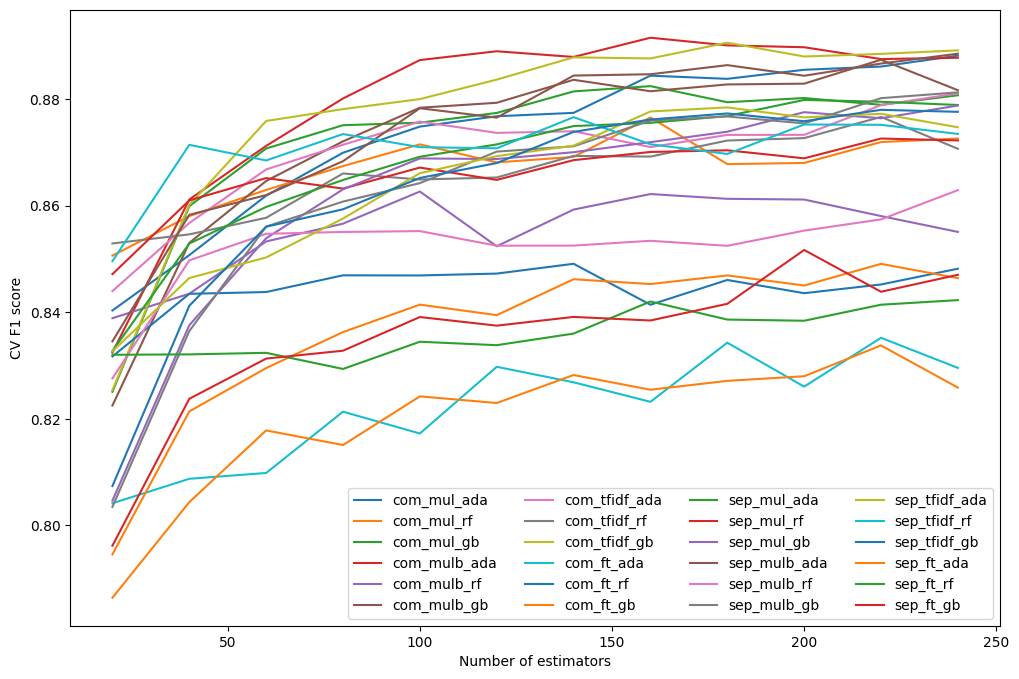

In [97]:
# See how many estimators we really need

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
for name, grid in tree_pipeline_results.items():
    ax.plot(n_estimators, grid.cv_results_['mean_test_f1'], label=name)
ax.set_xlabel('Number of estimators')
ax.set_ylabel('CV F1 score')
ax.legend(ncol=4)
plt.show()

Seems like approximately 150 estimators is enough.

In [102]:
# See which one is the best

best_tree_pipeline = max(tree_pipeline_results, key=lambda x: tree_pipeline_results[x].best_score_)
print(best_tree_pipeline)
print(tree_pipeline_results[best_tree_pipeline].best_score_)
print(tree_pipeline_results[best_tree_pipeline].best_params_)

com_mulb_ada
0.891546558722941
{'clf__n_estimators': 160}


At this value of `n_estimators`, how do the models compare?

In [116]:
i = np.argwhere(np.array(n_estimators) == 160)[0][0]

models_at_160 = {name: grid.cv_results_['mean_test_f1'][i] for name, grid in tree_pipeline_results.items()}
for model in sorted(models_at_160.items(), key=lambda x: x[1], reverse=True):
    print(model)

('com_mulb_ada', 0.891546558722941)
('com_tfidf_gb', 0.8876592619542072)
('sep_mulb_ada', 0.8846895936323665)
('com_mul_ada', 0.8844252810196782)
('com_mul_gb', 0.8824552697597593)
('com_mulb_gb', 0.8814980398898096)
('sep_tfidf_ada', 0.8776987042274678)
('com_mul_rf', 0.8765714586753834)
('sep_tfidf_gb', 0.8761918538102288)
('sep_mulb_gb', 0.8759877600669432)
('sep_mul_ada', 0.8755612648349503)
('sep_mul_gb', 0.8719377492626179)
('sep_tfidf_rf', 0.871537255567608)
('com_tfidf_ada', 0.871013617891632)
('sep_mul_rf', 0.8700940526514668)
('com_tfidf_rf', 0.869226834754359)
('com_mulb_rf', 0.8621911393824725)
('sep_mulb_rf', 0.8534136778737246)
('com_ft_gb', 0.8452881733833297)
('sep_ft_rf', 0.8420140609701308)
('com_ft_rf', 0.8414051304694279)
('sep_ft_gb', 0.8384481062135609)
('sep_ft_ada', 0.8254464925915992)
('com_ft_ada', 0.8231751137183572)


We should maybe check `max_depth` for the `gb` algorithms as well.
It seems clear enough that `tfidf` and `mulb` are the best featurisers, too.

In [120]:
depth_cv = {}
max_depth = [3, 5, 7]
print(max_depth)

for name, pipeline in pipelines.items():
    if any(name.endswith(x) for x in ['rf', 'gb']):
        print(f'Running CV on {name}')
        depth_cv[name] = GridSearchCV(
            pipeline,
            param_grid={
                'clf__max_depth': max_depth,
                'clf__n_estimators': [160]
            },
            scoring={
                'sensitivity': make_scorer(recall_score, pos_label=1),
                'specificity': make_scorer(recall_score, pos_label=0),
                'precision': make_scorer(precision_score),
                'f1': make_scorer(f1_score),
            },
            refit='f1',
            verbose=2
        )
        depth_cv[name].fit(X_train, y_train)

[3, 5, 7]
Running CV on com_mul_rf
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ............clf__max_depth=3, clf__n_estimators=160; total time=   0.6s
[CV] END ............clf__max_depth=3, clf__n_estimators=160; total time=   0.6s
[CV] END ............clf__max_depth=3, clf__n_estimators=160; total time=   0.5s
[CV] END ............clf__max_depth=3, clf__n_estimators=160; total time=   0.5s
[CV] END ............clf__max_depth=3, clf__n_estimators=160; total time=   0.5s
[CV] END ............clf__max_depth=5, clf__n_estimators=160; total time=   0.6s
[CV] END ............clf__max_depth=5, clf__n_estimators=160; total time=   0.6s
[CV] END ............clf__max_depth=5, clf__n_estimators=160; total time=   0.6s
[CV] END ............clf__max_depth=5, clf__n_estimators=160; total time=   0.7s
[CV] END ............clf__max_depth=5, clf__n_estimators=160; total time=   0.6s
[CV] END ............clf__max_depth=7, clf__n_estimators=160; total time=   0.7s
[CV] END .....

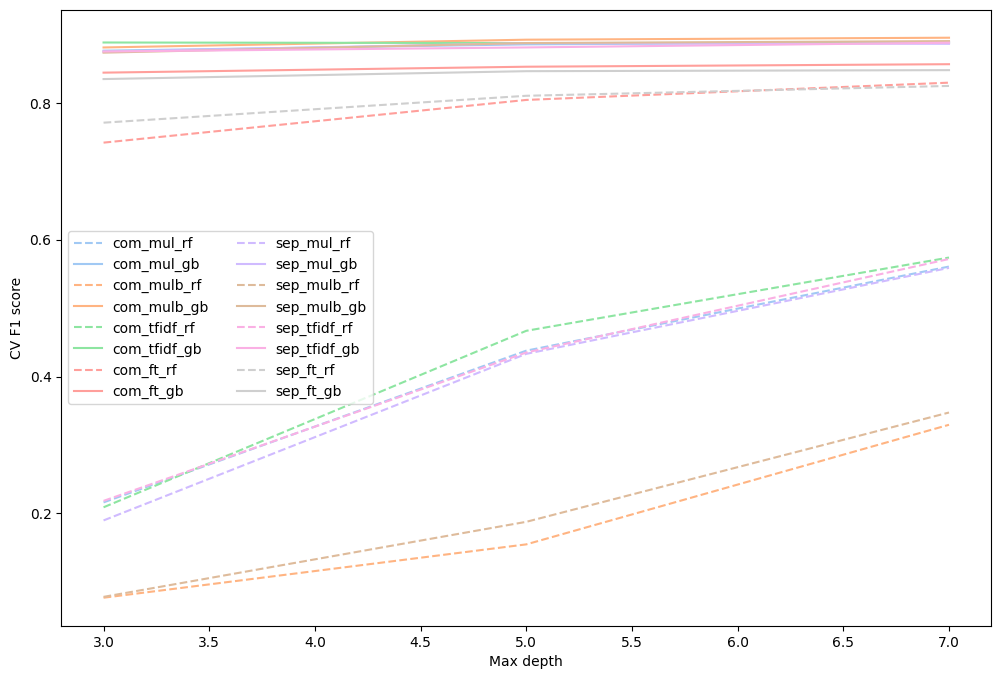

In [124]:
# Check effect of max_depth

import matplotlib.pyplot as plt
import seaborn as sns

pastel = sns.color_palette('pastel')

fig, ax = plt.subplots(figsize=(12, 8))
for name, grid in depth_cv.items():
    ax.plot(max_depth, grid.cv_results_['mean_test_f1'], label=name,
            linestyle='--' if 'rf' in name else '-',
            color=pastel[0] if 'com_mul_' in name
            else pastel[1] if 'com_mulb_' in name
            else pastel[2] if 'com_tfidf_' in name
            else pastel[3] if 'com_ft_' in name
            else pastel[4] if 'sep_mul_' in name
            else pastel[5] if 'sep_mulb_' in name
            else pastel[6] if 'sep_tfidf_' in name
            else pastel[7] if 'sep_ft_' in name
            else 'black')
ax.set_xlabel('Max depth')
ax.set_ylabel('CV F1 score')
ax.legend(ncol=2)
plt.show()

In [130]:
trees = {name: (np.max(grid.cv_results_['mean_test_f1']), max_depth[np.argmax(grid.cv_results_['mean_test_f1'])]) for name, grid in depth_cv.items()}
for model in sorted(trees.items(), key=lambda x: x[1][0], reverse=True):
    print(model)

('com_mulb_gb', (0.8952994511480554, 7))
('sep_mulb_gb', (0.8903458373834374, 7))
('com_mul_gb', (0.888866275678545, 7))
('com_tfidf_gb', (0.8883226553672788, 3))
('sep_tfidf_gb', (0.8880203003459508, 7))
('sep_mul_gb', (0.8873428252820554, 5))
('com_ft_gb', (0.8565859595463312, 7))
('sep_ft_gb', (0.8479028263892863, 7))
('com_ft_rf', (0.8296034139744979, 7))
('sep_ft_rf', (0.8248209259665729, 7))
('com_tfidf_rf', (0.5739311920480852, 7))
('sep_tfidf_rf', (0.5718031949597918, 7))
('com_mul_rf', (0.5607421825856237, 7))
('sep_mul_rf', (0.5588031300263123, 7))
('sep_mulb_rf', (0.3473672809480212, 7))
('com_mulb_rf', (0.3294427410417679, 7))


Seems like `com_mulb_gb` with `max_depth=7` does even better ...

In [134]:
# Train the model
optimised_model = Pipeline([
        ('vec', ColumnTransformer([("post", CountVectorizer(ngram_range=(1, 2)), "post")])),
        ('clf', GradientBoostingClassifier(n_estimators=160, max_depth=7))
])
optimised_model.fit(X_train, y_train)

# Save the model to disk
import pickle
os.system('mkdir -p models')
with open('models/com_mulb_gb_opt.pkl', 'wb') as f:
        pickle.dump(optimised_model, f)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1135
           1       0.94      0.88      0.90       330

    accuracy                           0.96      1465
   macro avg       0.95      0.93      0.94      1465
weighted avg       0.96      0.96      0.96      1465



f1 score: 0.905


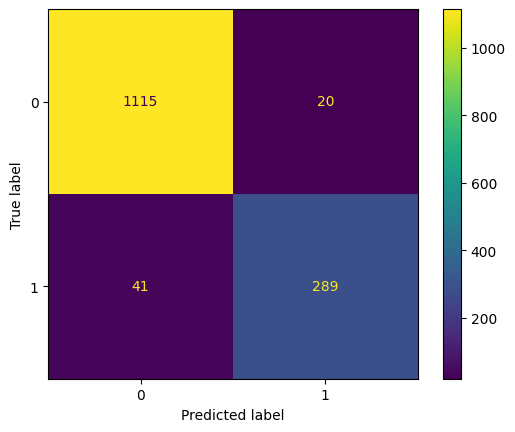

In [135]:
# Predict on test set (to check generalisability)
y_pred = optimised_model.predict(X_test)
print(f'f1 score: {f1_score(y_test, y_pred):.3f}')

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

# Check whether cutting off excess features makes a difference

In [137]:
# Train the model
gbc = Pipeline([
        ('vec', ColumnTransformer([("post", CountVectorizer(ngram_range=(1, 2)), "post")])),
        ('clf', GradientBoostingClassifier(n_estimators=160, max_depth=7))
])

features_cv = GridSearchCV(
    gbc,
    param_grid={
        'vec__post__max_features': [5000, 10000, 20000, 40000, None],
    },
    scoring={
        'sensitivity': make_scorer(recall_score, pos_label=1),
        'specificity': make_scorer(recall_score, pos_label=0),
        'precision': make_scorer(precision_score),
        'f1': make_scorer(f1_score),
    },
    refit='f1',
    verbose=2
)
features_cv.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END .......................vec__post__max_features=5000; total time=  11.4s
[CV] END .......................vec__post__max_features=5000; total time=  11.3s
[CV] END .......................vec__post__max_features=5000; total time=  11.2s
[CV] END .......................vec__post__max_features=5000; total time=  11.1s
[CV] END .......................vec__post__max_features=5000; total time=  11.2s
[CV] END ......................vec__post__max_features=10000; total time=  14.1s
[CV] END ......................vec__post__max_features=10000; total time=  14.2s
[CV] END ......................vec__post__max_features=10000; total time=  14.3s
[CV] END ......................vec__post__max_features=10000; total time=  14.0s
[CV] END ......................vec__post__max_features=10000; total time=  14.2s
[CV] END ......................vec__post__max_features=20000; total time=  18.8s
[CV] END ......................vec__post__max_fea

GridSearchCV(estimator=Pipeline(steps=[('vec',
                                        ColumnTransformer(transformers=[('post',
                                                                         CountVectorizer(ngram_range=(1,
                                                                                                      2)),
                                                                         'post')])),
                                       ('clf',
                                        GradientBoostingClassifier(max_depth=7,
                                                                   n_estimators=160))]),
             param_grid={'vec__post__max_features': [5000, 10000, 20000, 40000,
                                                     None]},
             refit='f1',
             scoring={'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score),
                      'sensitivity': make_scorer(recall_score, pos_label=1),
                      'specificity': make_scorer(recall_score, pos_label=0)},
             verbose=2)

In [155]:
print([f['vec__post__max_features'] for f in features_cv.cv_results_['params']])
print(features_cv.cv_results_['mean_test_f1'])

[5000, 10000, 20000, 40000, None]
[0.90385337 0.89826279 0.89606904 0.89754642 0.89481021]


In [156]:
features_cv2 = GridSearchCV(
    gbc,
    param_grid={
        'vec__post__max_features': [5000],
        'clf__max_depth': [3, 5, 7],
        'clf__n_estimators': [120, 160, 200]
    },
    scoring={
        'sensitivity': make_scorer(recall_score, pos_label=1),
        'specificity': make_scorer(recall_score, pos_label=0),
        'precision': make_scorer(precision_score),
        'f1': make_scorer(f1_score),
    },
    refit='f1',
    verbose=2
)
features_cv2.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END clf__max_depth=3, clf__n_estimators=120, vec__post__max_features=5000; total time=   3.7s
[CV] END clf__max_depth=3, clf__n_estimators=120, vec__post__max_features=5000; total time=   3.5s
[CV] END clf__max_depth=3, clf__n_estimators=120, vec__post__max_features=5000; total time=   3.5s
[CV] END clf__max_depth=3, clf__n_estimators=120, vec__post__max_features=5000; total time=   3.5s
[CV] END clf__max_depth=3, clf__n_estimators=120, vec__post__max_features=5000; total time=   3.5s
[CV] END clf__max_depth=3, clf__n_estimators=160, vec__post__max_features=5000; total time=   4.4s
[CV] END clf__max_depth=3, clf__n_estimators=160, vec__post__max_features=5000; total time=   4.3s
[CV] END clf__max_depth=3, clf__n_estimators=160, vec__post__max_features=5000; total time=   4.4s
[CV] END clf__max_depth=3, clf__n_estimators=160, vec__post__max_features=5000; total time=   4.3s
[CV] END clf__max_depth=3, clf__n_estimators=160,

GridSearchCV(estimator=Pipeline(steps=[('vec',
                                        ColumnTransformer(transformers=[('post',
                                                                         CountVectorizer(ngram_range=(1,
                                                                                                      2)),
                                                                         'post')])),
                                       ('clf',
                                        GradientBoostingClassifier(max_depth=7,
                                                                   n_estimators=160))]),
             param_grid={'clf__max_depth': [3, 5, 7],
                         'clf__n_estimators': [120, 160, 200],
                         'vec__post__max_features': [5000]},
             refit='f1',
             scoring={'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score),
                      'sensitivity': make_scorer(recall_score, pos_label=1),
                      'specificity': make_scorer(recall_score, pos_label=0)},
             verbose=2)

In [159]:
for p, test_f1 in zip(features_cv2.cv_results_['params'], features_cv2.cv_results_['mean_test_f1']):
    print(p, test_f1)

{'clf__max_depth': 3, 'clf__n_estimators': 120, 'vec__post__max_features': 5000} 0.8886188519114802
{'clf__max_depth': 3, 'clf__n_estimators': 160, 'vec__post__max_features': 5000} 0.8910922032217478
{'clf__max_depth': 3, 'clf__n_estimators': 200, 'vec__post__max_features': 5000} 0.8932730586387205
{'clf__max_depth': 5, 'clf__n_estimators': 120, 'vec__post__max_features': 5000} 0.8962640683927786
{'clf__max_depth': 5, 'clf__n_estimators': 160, 'vec__post__max_features': 5000} 0.8955363240462433
{'clf__max_depth': 5, 'clf__n_estimators': 200, 'vec__post__max_features': 5000} 0.8995332942711147
{'clf__max_depth': 7, 'clf__n_estimators': 120, 'vec__post__max_features': 5000} 0.9004825843369003
{'clf__max_depth': 7, 'clf__n_estimators': 160, 'vec__post__max_features': 5000} 0.9019461712246273
{'clf__max_depth': 7, 'clf__n_estimators': 200, 'vec__post__max_features': 5000} 0.9055233545933801


# XGBoost

In [169]:
import xgboost as xgb

xg = Pipeline([
        ('vec', ColumnTransformer([("post", CountVectorizer(ngram_range=(1, 2)), "post")])),
        ('clf', xgb.XGBClassifier(objective='binary:logistic')),
])

xg_cv = GridSearchCV(
    xg,
    param_grid={
        'vec__post__max_features': [5000, 10000, 20000, 40000, None],
        'clf__max_depth': [3, 5, 7],
        'clf__n_estimators': [120, 160, 200]
    },
    scoring={
        'sensitivity': make_scorer(recall_score, pos_label=1),
        'specificity': make_scorer(recall_score, pos_label=0),
        'precision': make_scorer(precision_score),
        'f1': make_scorer(f1_score),
    },
    refit='f1'
)
xg_cv.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('vec',
                                        ColumnTransformer(transformers=[('post',
                                                                         CountVectorizer(ngram_range=(1,
                                                                                                      2)),
                                                                         'post')])),
                                       ('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=Non...
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'clf__max_depth': [3, 5, 7],
                         'clf__n_estimators': [120, 160, 200],
                         'vec__post__max_features': [5000, 10000, 20000, 40000,
                                                     None]},
             refit='f1',
             scoring={'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score),
                      'sensitivity': make_scorer(recall_score, pos_label=1),
                      'specificity': make_scorer(recall_score, pos_label=0)})

In [170]:
for p, test_f1 in zip(xg_cv.cv_results_['params'], xg_cv.cv_results_['mean_test_f1']):
    print(p, test_f1)

{'clf__max_depth': 3, 'clf__n_estimators': 120, 'vec__post__max_features': 5000} 0.901695925061367
{'clf__max_depth': 3, 'clf__n_estimators': 120, 'vec__post__max_features': 10000} 0.9008615854198
{'clf__max_depth': 3, 'clf__n_estimators': 120, 'vec__post__max_features': 20000} 0.9006837035427582
{'clf__max_depth': 3, 'clf__n_estimators': 120, 'vec__post__max_features': 40000} 0.9006837035427582
{'clf__max_depth': 3, 'clf__n_estimators': 120, 'vec__post__max_features': None} 0.9006837035427582
{'clf__max_depth': 3, 'clf__n_estimators': 160, 'vec__post__max_features': 5000} 0.9033041295314737
{'clf__max_depth': 3, 'clf__n_estimators': 160, 'vec__post__max_features': 10000} 0.9037206164726743
{'clf__max_depth': 3, 'clf__n_estimators': 160, 'vec__post__max_features': 20000} 0.9055459153205179
{'clf__max_depth': 3, 'clf__n_estimators': 160, 'vec__post__max_features': 40000} 0.9055459153205179
{'clf__max_depth': 3, 'clf__n_estimators': 160, 'vec__post__max_features': None} 0.905545915320517

# Examining misclassified cases

In [173]:
# Optimised XGBoost model

from sklearn.model_selection import cross_val_predict

opt_xg = Pipeline([
    ('vec', ColumnTransformer([("post", CountVectorizer(ngram_range=(1, 2), max_features=5000), "post")])),
    ('clf', xgb.XGBClassifier(max_depth=7, n_estimators=200, objective='binary:logistic')),
])

y_train_pred = cross_val_predict(opt_xg, X_train, y_train, cv=5)

In [187]:
false_positives = X_train.iloc[(y_train_pred == 1) & (y_train == 0), :].loc[:, ['id', 'post']]
false_positives.to_csv('false_positives.csv', index=False)

2 of the 153 false positives are mislabelled, so that's ok

In [188]:
false_negatives = X_train.iloc[(y_train_pred == 0) & (y_train == 1), :].loc[:, ['id', 'post']]
false_negatives.to_csv('false_negatives.csv', index=False)

Looking at these, there are a lot of mislabelled posts! 41/92 of these were actually positives

In [189]:
# Let's sample 50 true negatives to see if there's any significant mislabelling
true_negatives = X_train.iloc[(y_train_pred == 0) & (y_train == 0), :].loc[:, ['id', 'post']]
true_negatives.sample(50).to_csv('true_negatives_some.csv', index=False)

... after looking through 50 posts labelled as 0, only 1 was mislabelled

# Retraining to be done in a separate notebook.